In [ ]:
%pip install import pandas as pd
import numpy aseaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_26335/3948858085.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                  │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,235 (504.82 KB)

 Trainable params: 129,235 (504.82 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM (Super Aggressive)...
Epoch 1/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0109 - val_loss: 0.0059
Epoch 2/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 3/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 4/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 11/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 12/50
923

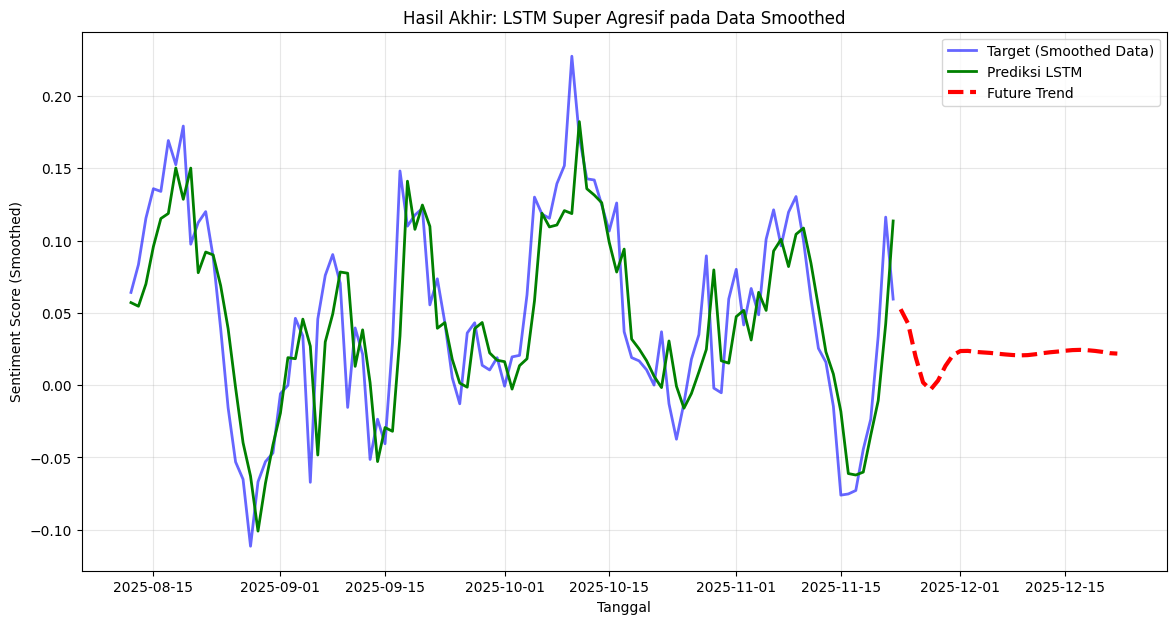

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ==========================================
# 1. PERSIAPAN DATA + SMOOTHING
# ==========================================
# Ganti path file ini sesuai dengan lokasi file Anda
INPUT_FILE = "data_with_sentiment_score.csv" 
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)

START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()

df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
dataset = df_smooth.values.reshape(-1, 1)

# ==========================================
# 2. WINDOWING
# ==========================================
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

LOOK_BACK = 30

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(scaled_data, LOOK_BACK)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.9)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# ======================================================================
# 3. MODEL "AGRESIF SUPER" (PENINGKATAN DARI MODEL TERBAIK)
# ======================================================================
model = Sequential()

# PENINGKATAN 1: Lapisan Pertama lebih besar
model.add(LSTM(128, return_sequences=True, input_shape=(LOOK_BACK, 1)))

# PENINGKATAN 2: Menambahkan Lapisan LSTM ketiga (lebih dalam)
model.add(LSTM(64, return_sequences=True)) # Lapisan tengah yang baru
model.add(LSTM(32, return_sequences=False)) # Lapisan terakhir sebelum Dense

# PENINGKATAN 3: Lapisan Dense dengan LeakyReLU
model.add(Dense(25)) 
model.add(LeakyReLU(alpha=0.05)) # Alternatif dari ReLU

# Output Layer
model.add(Dense(1))

# Kita gunakan kembali learning rate terbaik dari model pemenang
optimizer = Adam(learning_rate=0.0005) 
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

print("\nTraining LSTM (Super Aggressive)...")

# Kita tetap gunakan EarlyStopping untuk mencegah training yang terlalu lama
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=1, # Tetap 1, karena ini adalah inti dari strategi agresif
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=1
)

# ==========================================
# 4. PREDIKSI & EVALUASI
# ==========================================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Balikin ke skala asli
train_predict_inv = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict_inv = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrik Evaluasi
print("\n📊 Menghitung Metrik Evaluasi...")
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_r2 = r2_score(y_train_inv, train_predict_inv)
print(f"\n--- Metrik TRAINING SET ---")
print(f"MAE (Rata-rata Error) : {train_mae:.5f}")
print(f"R2 Score              : {train_r2:.5f}")

test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
print(f"\n--- Metrik TEST SET ---")
print(f"MAE (Rata-rata Error) : {test_mae:.5f}")
print(f"R2 Score              : {test_r2:.5f}")

# ==========================================
# 5. PREDIKSI MASA DEPAN & PLOTTING
# ==========================================
DAYS_TO_PREDICT = 30
curr_input = scaled_data[-LOOK_BACK:].reshape(1, LOOK_BACK, 1)
future_preds = []

for i in range(DAYS_TO_PREDICT):
    pred = model.predict(curr_input, verbose=0)
    future_preds.append(scaler.inverse_transform(pred)[0][0])
    curr_input = np.append(curr_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Visualisasi Hasil
plt.figure(figsize=(14, 7))

test_dates = df_smooth.index[train_size + LOOK_BACK + 1 : len(df_smooth)]
plt.plot(test_dates, y_test_inv.flatten(), label='Target (Smoothed Data)', color='blue', linewidth=2, alpha=0.6)
plt.plot(test_dates, test_predict_inv.flatten(), label='Prediksi LSTM', color='green', linewidth=2)
future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), periods=DAYS_TO_PREDICT)
plt.plot(future_dates, future_preds, label='Future Trend', color='red', linewidth=3, linestyle='--')

plt.title("Hasil Akhir: LSTM Super Agresif pada Data Smoothed")
plt.xlabel("Tanggal")
plt.ylabel("Sentiment Score (Smoothed)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training LSTM (Batch Size=1)... Ini mungkin agak lama tapi detail...
Epoch 1/50


/tmp/ipykernel_26335/940580354.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


923/923 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0092 - val_loss: 0.0040
Epoch 2/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 3/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 7/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 8/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 9/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 10/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 11/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 12/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.

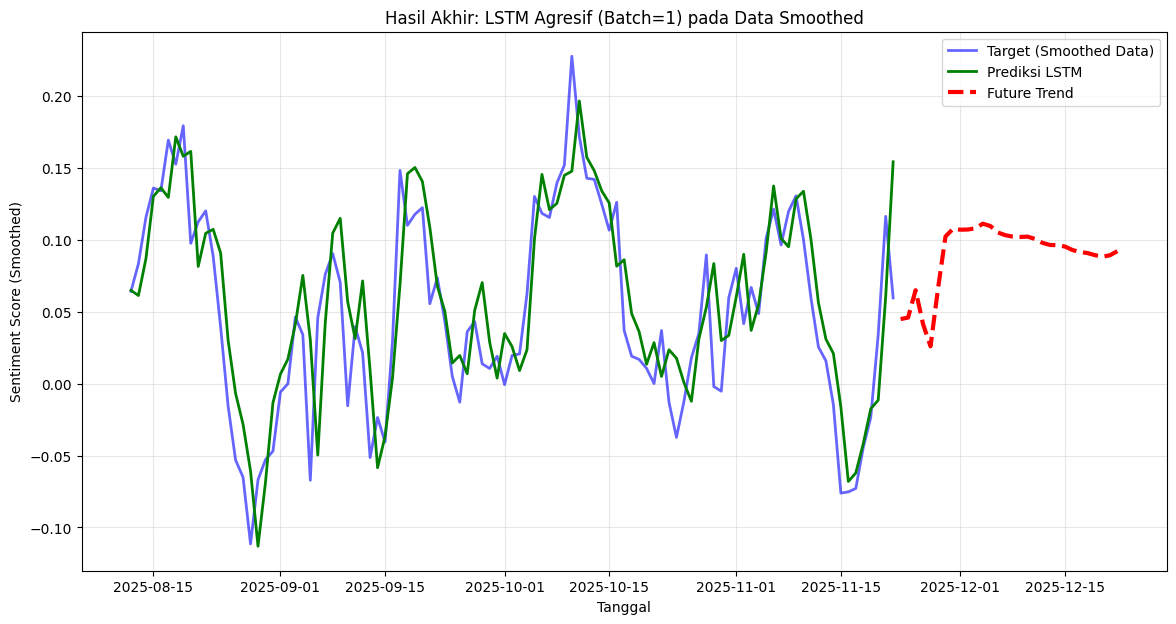

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# DITAMBAHKAN: Import untuk metrik evaluasi
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# ==========================================
# 1. PERSIAPAN DATA + SMOOTHING
# ==========================================
INPUT_FILE = "data_with_sentiment_score.csv"
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)

START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()

# Resample Harian
df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()

# >>> TRIK UTAMA: DATA DI-HALUSKAN (Moving Average 7 Hari) <<<
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')

dataset = df_smooth.values.reshape(-1, 1)

# ==========================================
# 2. WINDOWING
# ==========================================
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

LOOK_BACK = 30

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(scaled_data, LOOK_BACK)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split Data (90% Training agar data pelatihannya banyak)
train_size = int(len(X) * 0.9)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# ==========================================
# 3. MODEL LSTM "AGRESIF"
# ==========================================
model = Sequential()

# Layer LSTM Besar Tanpa Dropout
model.add(LSTM(100, return_sequences=True, input_shape=(LOOK_BACK, 1)))
model.add(LSTM(50, return_sequences=False))

# Output Layer
model.add(Dense(1))

# Learning Rate dikecilkan sedikit biar belajarnya teliti
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

print("Training LSTM (Batch Size=1)... Ini mungkin agak lama tapi detail...")

# BATCH SIZE = 1 adalah KUNCI agar grafik tidak datar
history = model.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=1, 
    validation_data=(X_test, y_test),
    verbose=1
)

# ==========================================
# 4. PREDIKSI & EVALUASI
# ==========================================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Balikin ke skala asli
train_predict_inv = scaler.inverse_transform(train_predict)
# DIPERBAIKI: Menggunakan .reshape() agar dimensi array benar
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1)) 
test_predict_inv = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- DITAMBAHKAN: Bagian Metrik Evaluasi ---
print("\n📊 Menghitung Metrik Evaluasi...")

# --- Metrik TRAINING SET ---
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
train_r2 = r2_score(y_train_inv, train_predict_inv)
print(f"\n--- Metrik TRAINING SET ---")
print(f"MAE (Rata-rata Error) : {train_mae:.5f}")
print(f"RMSE (Akar Error)     : {train_rmse:.5f}")
print(f"R2 Score              : {train_r2:.5f} (Seberapa baik model cocok dengan data yang dilihatnya)")

# --- Metrik TEST SET ---
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_r2 = r2_score(y_test_inv, test_predict_inv)
print(f"\n--- Metrik TEST SET ---")
print(f"MAE (Rata-rata Error) : {test_mae:.5f}")
print(f"RMSE (Akar Error)     : {test_rmse:.5f}")
print(f"R2 Score              : {test_r2:.5f} (Metrik paling penting untuk performa di dunia nyata)")
# ----------------------------------------------


# ==========================================
# 5. PREDIKSI MASA DEPAN & PLOTTING
# ==========================================
DAYS_TO_PREDICT = 30
curr_input = scaled_data[-LOOK_BACK:].reshape(1, LOOK_BACK, 1)
future_preds = []

for i in range(DAYS_TO_PREDICT):
    pred = model.predict(curr_input, verbose=0)
    future_preds.append(scaler.inverse_transform(pred)[0][0])
    curr_input = np.append(curr_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Visualisasi Hasil
plt.figure(figsize=(14, 7))

test_dates = df_smooth.index[train_size + LOOK_BACK + 1 : len(df_smooth)]
plt.plot(test_dates, y_test_inv.flatten(), label='Target (Smoothed Data)', color='blue', linewidth=2, alpha=0.6)
plt.plot(test_dates, test_predict_inv.flatten(), label='Prediksi LSTM', color='green', linewidth=2)
future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), periods=DAYS_TO_PREDICT)
plt.plot(future_dates, future_preds, label='Future Trend', color='red', linewidth=3, linestyle='--')

plt.title("Hasil Akhir: LSTM Agresif (Batch=1) pada Data Smoothed")
plt.xlabel("Tanggal")
plt.ylabel("Sentiment Score (Smoothed)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training LSTM (Batch Size=1)...
Epoch 1/50


/tmp/ipykernel_26335/3449162902.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


923/923 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 2/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 7/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 8/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 9/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 10/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 11/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 12/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.

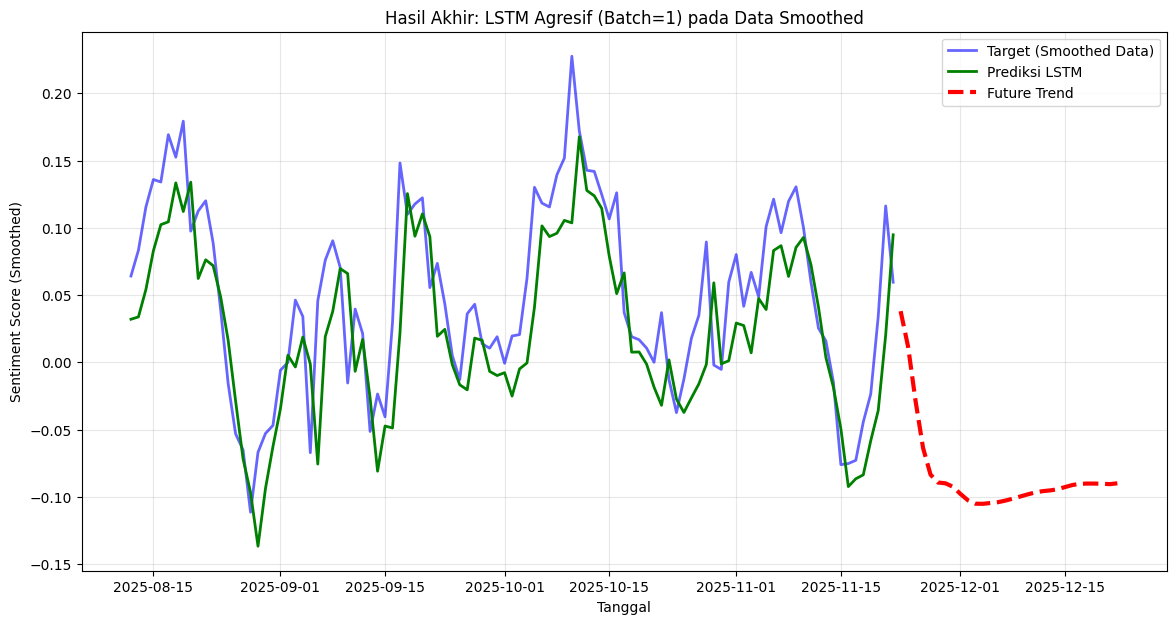

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# DITAMBAHKAN: Import library untuk seed
import os
import random
import tensorflow as tf

# ==========================================
# DITAMBAHKAN: MENETAPKAN SEED UNTUK REPRODUKSI HASIL
# ==========================================
# Letakkan ini di bagian paling atas script Anda
SEED = 42  # Angka 42 adalah konvensi, bisa diganti angka lain yang Anda suka
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# ==========================================


# ==========================================
# 1. PERSIAPAN DATA + SMOOTHING
# ==========================================
INPUT_FILE = "data_with_sentiment_score.csv"
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)

START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()

df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
dataset = df_smooth.values.reshape(-1, 1)

# ==========================================
# 2. WINDOWING
# ==========================================
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

LOOK_BACK = 30

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(scaled_data, LOOK_BACK)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.9)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# ==========================================
# 3. MODEL LSTM "AGRESIF"
# ==========================================
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(LOOK_BACK, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

print("Training LSTM (Batch Size=1)...")

history = model.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=1, 
    validation_data=(X_test, y_test),
    verbose=1
)

# ==========================================
# 4. PREDIKSI & EVALUASI
# ==========================================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_inv = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1)) 
test_predict_inv = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

print("\n📊 Menghitung Metrik Evaluasi...")

# --- Metrik TRAINING SET ---
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
train_r2 = r2_score(y_train_inv, train_predict_inv)
print(f"\n--- Metrik TRAINING SET ---")
print(f"MAE (Rata-rata Error) : {train_mae:.5f}")
print(f"RMSE (Akar Error)     : {train_rmse:.5f}")
print(f"R2 Score              : {train_r2:.5f}")

# --- Metrik TEST SET ---
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_r2 = r2_score(y_test_inv, test_predict_inv)
print(f"\n--- Metrik TEST SET ---")
print(f"MAE (Rata-rata Error) : {test_mae:.5f}")
print(f"RMSE (Akar Error)     : {test_rmse:.5f}")
print(f"R2 Score              : {test_r2:.5f}")


# ==========================================
# 5. PREDIKSI MASA DEPAN & PLOTTING
# ==========================================
DAYS_TO_PREDICT = 30
curr_input = scaled_data[-LOOK_BACK:].reshape(1, LOOK_BACK, 1)
future_preds = []

for i in range(DAYS_TO_PREDICT):
    pred = model.predict(curr_input, verbose=0)
    future_preds.append(scaler.inverse_transform(pred)[0][0])
    curr_input = np.append(curr_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Visualisasi Hasil
plt.figure(figsize=(14, 7))

test_dates = df_smooth.index[train_size + LOOK_BACK + 1 : len(df_smooth)]
plt.plot(test_dates, y_test_inv.flatten(), label='Target (Smoothed Data)', color='blue', linewidth=2, alpha=0.6)
plt.plot(test_dates, test_predict_inv.flatten(), label='Prediksi LSTM', color='green', linewidth=2)
future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), periods=DAYS_TO_PREDICT)
plt.plot(future_dates, future_preds, label='Future Trend', color='red', linewidth=3, linestyle='--')

plt.title("Hasil Akhir: LSTM Agresif (Batch=1) pada Data Smoothed")
plt.xlabel("Tanggal")
plt.ylabel("Sentiment Score (Smoothed)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_26335/1922432932.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                  │ (None, 30, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,851 (280.67 KB)

 Trainable params: 71,851 (280.67 KB)

 Non-trainable params: 0 (0.00 B)

Training Multi-Feature LSTM (Robust Aggressive)...
Epoch 1/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0064 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 2/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0019 - val_loss: 0.0018 - learning_rate: 5.0000e-04
Epoch 3/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 0.0018 - learning_rate: 5.0000e-04
Epoch 4/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 5/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0016 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 6/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 7/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 8/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0015 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 9/150
923/923 ━━━━━━━━━

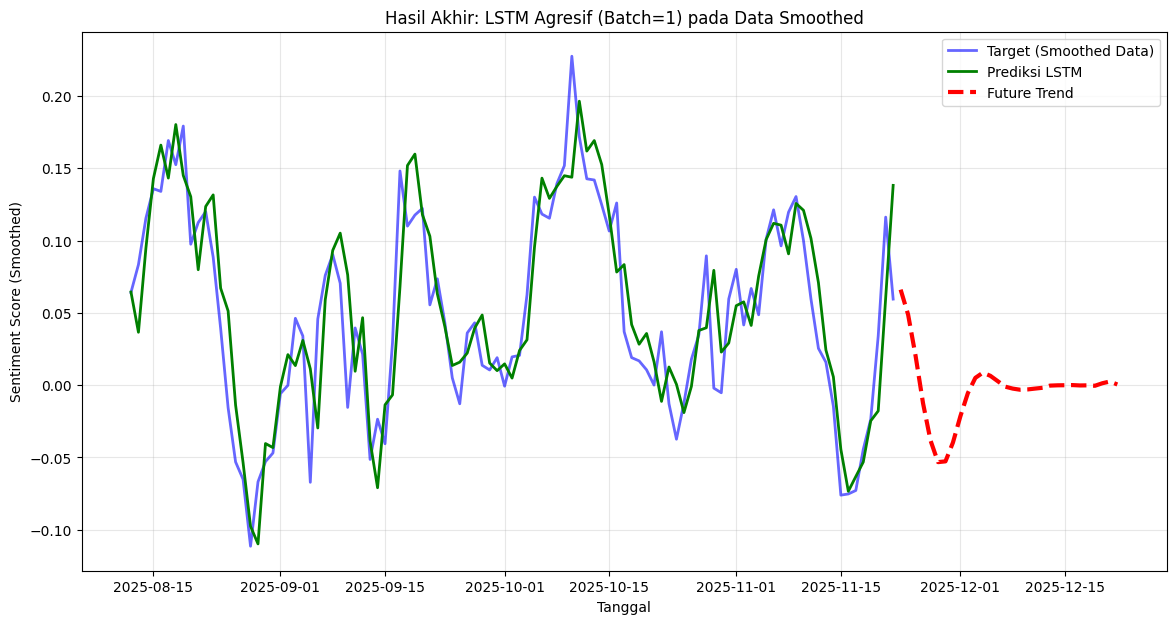

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Menetapkan Seed untuk hasil yang konsisten
import os
import random
import tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================================
# 1. PERSIAPAN DATA + FEATURE ENGINEERING
# ==========================================
INPUT_FILE = "data_with_sentiment_score.csv"
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)
START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()
df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')

# PENINGKATAN: MEMBUAT FITUR BARU
df_features = pd.DataFrame(index=df_smooth.index)
df_features['smoothed'] = df_smooth # Fitur 1: Tren halus (target utama kita)
df_features['raw_daily'] = df_daily # Fitur 2: Nilai harian asli (konteks volatilitas)
df_features['momentum'] = df_smooth.diff().fillna(0) # Fitur 3: Kecepatan tren

# Scaling semua fitur bersama-sama
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features)
n_features = scaled_data.shape[1]

# ==========================================
# 2. WINDOWING UNTUK MULTI-FITUR
# ==========================================
LOOK_BACK = 30
def create_dataset_multi(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        # Input (X) adalah semua fitur dari window
        dataX.append(dataset[i:(i + look_back), :])
        # Output (Y) adalah nilai 'smoothed' di hari berikutnya (kolom pertama)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset_multi(scaled_data, LOOK_BACK)
train_size = int(len(X) * 0.9)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# ==========================================
# 3. MODEL AGRESIF MULTI-FITUR + PELATIHAN TANGGUH
# ==========================================
model = Sequential()
# Input shape sekarang memiliki n_features
model.add(LSTM(100, return_sequences=True, input_shape=(LOOK_BACK, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

print("Training Multi-Feature LSTM (Robust Aggressive)...")

callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=1, # Tetap agresif
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=1
)

# ==========================================
# 4. PREDIKSI & EVALUASI UNTUK MULTI-FITUR
# ==========================================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Helper function untuk inverse transform
def inverse_transform_multi(scaler, predictions, y_true):
    # Buat dummy array dengan shape (jumlah_sample, jumlah_fitur)
    pred_dummy = np.zeros((len(predictions), n_features))
    true_dummy = np.zeros((len(y_true), n_features))
    # Isi kolom pertama (kolom target) dengan nilai prediksi dan nilai asli
    pred_dummy[:, 0] = predictions.flatten()
    true_dummy[:, 0] = y_true.flatten()
    # Inverse transform dan ambil hanya kolom pertama
    pred_inv = scaler.inverse_transform(pred_dummy)[:, 0]
    true_inv = scaler.inverse_transform(true_dummy)[:, 0]
    return pred_inv, true_inv

train_predict_inv, y_train_inv = inverse_transform_multi(scaler, train_predict, y_train)
test_predict_inv, y_test_inv = inverse_transform_multi(scaler, test_predict, y_test)
print("\n📊 Menghitung Metrik Evaluasi...")

# --- Metrik TRAINING SET ---
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
train_r2 = r2_score(y_train_inv, train_predict_inv)
print(f"\n--- Metrik TRAINING SET ---")
print(f"MAE (Rata-rata Error) : {train_mae:.5f}")
print(f"RMSE (Akar Error)     : {train_rmse:.5f}")
print(f"R2 Score              : {train_r2:.5f}")

# --- Metrik TEST SET ---
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_r2 = r2_score(y_test_inv, test_predict_inv)
print(f"\n--- Metrik TEST SET ---")
print(f"MAE (Rata-rata Error) : {test_mae:.5f}")
print(f"RMSE (Akar Error)     : {test_rmse:.5f}")
print(f"R2 Score              : {test_r2:.5f}")

# ==========================================
# 5. PREDIKSI MASA DEPAN DINAMIS
# ==========================================
DAYS_TO_PREDICT = 30
# Ambil window terakhir dari data asli (dengan semua fitur)
last_window_scaled = scaled_data[-LOOK_BACK:]
curr_input = last_window_scaled.reshape(1, LOOK_BACK, n_features)
future_preds_scaled = []

for i in range(DAYS_TO_PREDICT):
    # Prediksi nilai 'smoothed' berikutnya
    pred_scaled = model.predict(curr_input, verbose=0)
    future_preds_scaled.append(pred_scaled[0,0])
    
    # BUAT FITUR BARU UNTUK LANGKAH BERIKUTNYA
    # Fitur 'raw_daily' & 'momentum' kita asumsikan sama dengan nilai terakhir (simplifikasi)
    new_features = curr_input[0, -1, 1:]
    # Gabungkan prediksi 'smoothed' dengan fitur lainnya
    new_step_scaled = np.insert(new_features, 0, pred_scaled[0,0])
    
    # Update window input
    curr_input = np.append(curr_input[:, 1:, :], new_step_scaled.reshape(1, 1, n_features), axis=1)

# Inverse transform semua prediksi masa depan sekaligus
future_preds_dummy = np.zeros((len(future_preds_scaled), n_features))
future_preds_dummy[:, 0] = future_preds_scaled
future_preds = scaler.inverse_transform(future_preds_dummy)[:, 0]

# Visualisasi Hasil
plt.figure(figsize=(14, 7))

test_dates = df_smooth.index[train_size + LOOK_BACK + 1 : len(df_smooth)]
plt.plot(test_dates, y_test_inv.flatten(), label='Target (Smoothed Data)', color='blue', linewidth=2, alpha=0.6)
plt.plot(test_dates, test_predict_inv.flatten(), label='Prediksi LSTM', color='green', linewidth=2)
future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), periods=DAYS_TO_PREDICT)
plt.plot(future_dates, future_preds, label='Future Trend', color='red', linewidth=3, linestyle='--')

plt.title("Hasil Akhir: LSTM Agresif (Batch=1) pada Data Smoothed")
plt.xlabel("Tanggal")
plt.ylabel("Sentiment Score (Smoothed)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_26335/1218820131.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                  │ (None, 30, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,851 (280.67 KB)

 Trainable params: 71,851 (280.67 KB)

 Non-trainable params: 0 (0.00 B)

Training Multi-Feature LSTM (Robust Aggressive)...
Epoch 1/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0068 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 2/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0025 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 3/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0017 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 4/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0015 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 5/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 6/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0014 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 7/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0013 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 8/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0013 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 9/150
921/923 ━━━━━━

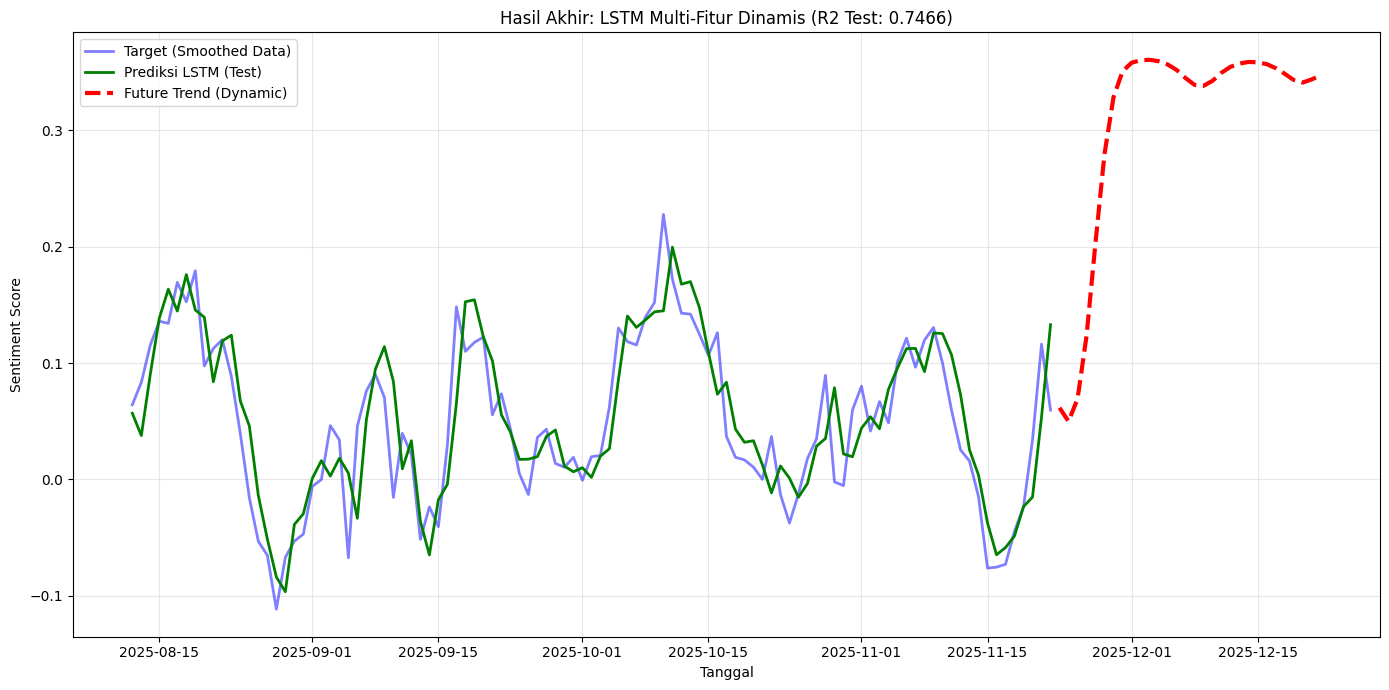

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Menetapkan Seed untuk hasil yang konsisten
import os
import random
import tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================================
# 1. PERSIAPAN DATA + FEATURE ENGINEERING
# ==========================================
INPUT_FILE = "data_with_sentiment_score.csv"
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)
START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()
df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')

# PENINGKATAN: MEMBUAT FITUR BARU
df_features = pd.DataFrame(index=df_smooth.index)
df_features['smoothed'] = df_smooth # Fitur 1: Tren halus (target utama kita)
df_features['raw_daily'] = df_daily # Fitur 2: Nilai harian asli (konteks volatilitas)
df_features['momentum'] = df_smooth.diff().fillna(0) # Fitur 3: Kecepatan tren

# Scaling semua fitur bersama-sama
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features)
n_features = scaled_data.shape[1]

# ==========================================
# 2. WINDOWING UNTUK MULTI-FITUR
# ==========================================
LOOK_BACK = 30
def create_dataset_multi(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        # Input (X) adalah semua fitur dari window
        dataX.append(dataset[i:(i + look_back), :])
        # Output (Y) adalah nilai 'smoothed' di hari berikutnya (kolom pertama)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset_multi(scaled_data, LOOK_BACK)
train_size = int(len(X) * 0.9)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# ==========================================
# 3. MODEL AGRESIF MULTI-FITUR + PELATIHAN TANGGUH
# ==========================================
model = Sequential()
# Input shape sekarang memiliki n_features
model.add(LSTM(100, return_sequences=True, input_shape=(LOOK_BACK, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Gunakan sigmoid untuk output antara 0-1

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

print("Training Multi-Feature LSTM (Robust Aggressive)...")

callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=1, # Tetap agresif
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=1
)

# ==========================================
# 4. PREDIKSI & EVALUASI UNTUK MULTI-FITUR
# ==========================================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Helper function untuk inverse transform
def inverse_transform_multi(scaler, predictions, y_true):
    # Buat dummy array dengan shape (jumlah_sample, jumlah_fitur)
    pred_dummy = np.zeros((len(predictions), n_features))
    true_dummy = np.zeros((len(y_true), n_features))
    # Isi kolom pertama (kolom target) dengan nilai prediksi dan nilai asli
    pred_dummy[:, 0] = predictions.flatten()
    true_dummy[:, 0] = y_true.flatten()
    # Inverse transform dan ambil hanya kolom pertama
    pred_inv = scaler.inverse_transform(pred_dummy)[:, 0]
    true_inv = scaler.inverse_transform(true_dummy)[:, 0]
    return pred_inv, true_inv

train_predict_inv, y_train_inv = inverse_transform_multi(scaler, train_predict, y_train)
test_predict_inv, y_test_inv = inverse_transform_multi(scaler, test_predict, y_test)
print("\n📊 Menghitung Metrik Evaluasi...")

# --- Metrik TRAINING SET ---
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
train_r2 = r2_score(y_train_inv, train_predict_inv)
print(f"\n--- Metrik TRAINING SET ---")
print(f"MAE (Rata-rata Error) : {train_mae:.5f}")
print(f"RMSE (Akar Error)     : {train_rmse:.5f}")
print(f"R2 Score              : {train_r2:.5f}")

# --- Metrik TEST SET ---
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_r2 = r2_score(y_test_inv, test_predict_inv)
print(f"\n--- Metrik TEST SET ---")
print(f"MAE (Rata-rata Error) : {test_mae:.5f}")
print(f"RMSE (Akar Error)     : {test_rmse:.5f}")
print(f"R2 Score              : {test_r2:.5f}")

DAYS_TO_PREDICT = 30
last_window_scaled = scaled_data[-LOOK_BACK:]
curr_input = last_window_scaled.reshape(1, LOOK_BACK, n_features)
# ... (kode sebelumnya tetap sama)

print("Memulai prediksi masa depan dengan LOGIKA PEREDAMAN (DAMPING)...")

# Setup variabel untuk loop
future_preds_scaled = []
curr_input = last_window_scaled.reshape(1, LOOK_BACK, n_features)

# PARAMETER PENTING UNTUK MENCEGAH GRAFIK TERBANG
MOMENTUM_DAMPING = 0.8  # Mengurangi kekuatan tren tiap langkah (0.8 = 80% kekuatan)
NOISE_LEVEL = 0.02      # Menambah sedikit variasi agar tidak terlalu mulus/palsu

for i in range(DAYS_TO_PREDICT):
    # 1. Prediksi
    pred_scaled = model.predict(curr_input, verbose=0)
    current_pred_val = pred_scaled[0, 0]
    
    # --- FIX A: CLIPPING (BATASI NILAI) ---
    # Karena data di-scale 0-1, kita paksa agar tidak boleh lewat dari 0 atau 1
    # Jika sentiment aslimu range -1 s/d 1, sesuaikan min/max-nya di scaler logic, 
    # tapi karena ini data scaled, batasi di 0.0 sampai 1.0
    current_pred_val = np.clip(current_pred_val, 0.0, 1.0)
    
    future_preds_scaled.append(current_pred_val)
    
    # 2. UPDATE FITUR DINAMIS DENGAN KONTROL
    previous_smoothed_val = curr_input[0, -1, 0]
    
    # --- FIX B: DAMPED MOMENTUM ---
    # Hitung momentum, tapi kalikan dengan damping factor agar tren lama-lama melemah
    raw_momentum = current_pred_val - previous_smoothed_val
    new_momentum = raw_momentum * (MOMENTUM_DAMPING ** (i + 1)) 
    
    # --- FIX C: RAW DATA DENGAN NOISE ---
    # Jangan buat raw data 100% sama dengan smoothed, tambahkan sedikit noise
    # Ini mencegah model terlalu percaya diri (overconfident)
    noise = np.random.normal(0, NOISE_LEVEL)
    new_raw = current_pred_val + noise
    
    # Gabungkan fitur
    new_step_features = np.array([current_pred_val, new_raw, new_momentum])
    
    # Update Window
    curr_input = np.append(curr_input[:, 1:, :], new_step_features.reshape(1, 1, n_features), axis=1)

# ... (lanjut ke inverse transform dan plotting)
# Inverse transform hasil prediksi
future_preds_dummy = np.zeros((len(future_preds_scaled), n_features))
future_preds_dummy[:, 0] = future_preds_scaled
future_preds = scaler.inverse_transform(future_preds_dummy)[:, 0]

# --- VISUALISASI HASIL PERBAIKAN ---
plt.figure(figsize=(14, 7))

# Plot Data Test
test_dates = df_smooth.index[train_size + LOOK_BACK + 1 : len(df_smooth)]
plt.plot(test_dates, y_test_inv.flatten(), label='Target (Smoothed Data)', color='blue', linewidth=2, alpha=0.5)
plt.plot(test_dates, test_predict_inv.flatten(), label='Prediksi LSTM (Test)', color='green', linewidth=2)

# Plot Data Masa Depan
future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), periods=DAYS_TO_PREDICT)
plt.plot(future_dates, future_preds, label='Future Trend (Dynamic)', color='red', linewidth=3, linestyle='--')

plt.title(f"Hasil Akhir: LSTM Multi-Fitur Dinamis (R2 Test: {test_r2:.4f})")
plt.xlabel("Tanggal")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

2025-12-01 10:29:50.735740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_6716/929134546.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
2025-12-01 10:29:56.134442: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in t

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,851 (280.67 KB)

 Trainable params: 71,851 (280.67 KB)

 Non-trainable params: 0 (0.00 B)

Training Multi-Feature LSTM (Robust Aggressive)...
Epoch 1/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0068 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 2/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0025 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 3/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0017 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 4/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0015 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 5/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 6/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0014 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 7/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0013 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 8/150
923/923 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0013 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 9/150
922/923 ━━━━━━━━

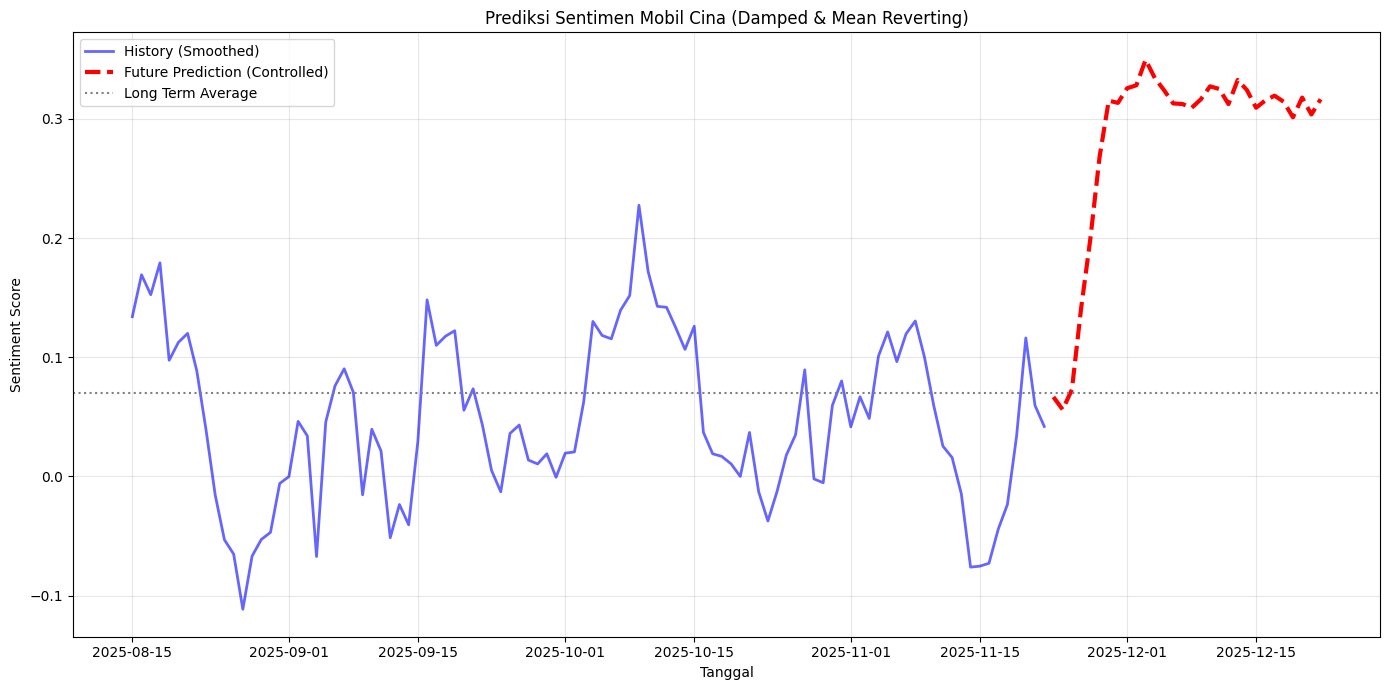

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Menetapkan Seed untuk hasil yang konsisten
import os
import random
import tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================================
# 1. PERSIAPAN DATA + FEATURE ENGINEERING
# ==========================================
INPUT_FILE = "data_with_sentiment_score.csv"
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)
START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()
df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')

# PENINGKATAN: MEMBUAT FITUR BARU
df_features = pd.DataFrame(index=df_smooth.index)
df_features['smoothed'] = df_smooth # Fitur 1: Tren halus (target utama kita)
df_features['raw_daily'] = df_daily # Fitur 2: Nilai harian asli (konteks volatilitas)
df_features['momentum'] = df_smooth.diff().fillna(0) # Fitur 3: Kecepatan tren

# Scaling semua fitur bersama-sama
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features)
n_features = scaled_data.shape[1]

# ==========================================
# 2. WINDOWING UNTUK MULTI-FITUR
# ==========================================
LOOK_BACK = 30
def create_dataset_multi(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        # Input (X) adalah semua fitur dari window
        dataX.append(dataset[i:(i + look_back), :])
        # Output (Y) adalah nilai 'smoothed' di hari berikutnya (kolom pertama)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset_multi(scaled_data, LOOK_BACK)
train_size = int(len(X) * 0.9)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# ==========================================
# 3. MODEL AGRESIF MULTI-FITUR + PELATIHAN TANGGUH
# ==========================================
model = Sequential()
# Input shape sekarang memiliki n_features
model.add(LSTM(100, return_sequences=True, input_shape=(LOOK_BACK, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Gunakan sigmoid untuk output antara 0-1

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

print("Training Multi-Feature LSTM (Robust Aggressive)...")

callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=1, # Tetap agresif
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=1
)

# ==========================================
# 4. PREDIKSI & EVALUASI UNTUK MULTI-FITUR
# ==========================================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Helper function untuk inverse transform
def inverse_transform_multi(scaler, predictions, y_true):
    # Buat dummy array dengan shape (jumlah_sample, jumlah_fitur)
    pred_dummy = np.zeros((len(predictions), n_features))
    true_dummy = np.zeros((len(y_true), n_features))
    # Isi kolom pertama (kolom target) dengan nilai prediksi dan nilai asli
    pred_dummy[:, 0] = predictions.flatten()
    true_dummy[:, 0] = y_true.flatten()
    # Inverse transform dan ambil hanya kolom pertama
    pred_inv = scaler.inverse_transform(pred_dummy)[:, 0]
    true_inv = scaler.inverse_transform(true_dummy)[:, 0]
    return pred_inv, true_inv

train_predict_inv, y_train_inv = inverse_transform_multi(scaler, train_predict, y_train)
test_predict_inv, y_test_inv = inverse_transform_multi(scaler, test_predict, y_test)
print("\n📊 Menghitung Metrik Evaluasi...")

# --- Metrik TRAINING SET ---
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
train_r2 = r2_score(y_train_inv, train_predict_inv)
print(f"\n--- Metrik TRAINING SET ---")
print(f"MAE (Rata-rata Error) : {train_mae:.5f}")
print(f"RMSE (Akar Error)     : {train_rmse:.5f}")
print(f"R2 Score              : {train_r2:.5f}")

# --- Metrik TEST SET ---
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_r2 = r2_score(y_test_inv, test_predict_inv)
print(f"\n--- Metrik TEST SET ---")
print(f"MAE (Rata-rata Error) : {test_mae:.5f}")
print(f"RMSE (Akar Error)     : {test_rmse:.5f}")
print(f"R2 Score              : {test_r2:.5f}")

DAYS_TO_PREDICT = 30
last_window_scaled = scaled_data[-LOOK_BACK:]
curr_input = last_window_scaled.reshape(1, LOOK_BACK, n_features)
# ... (kode sebelumnya tetap sama)

print("Memulai prediksi masa depan dengan MEAN REVERSION...")

# 1. Hitung Rata-rata Jangka Panjang (Anchor)
# Kita ambil rata-rata dari data train (scaled) sebagai titik gravitasi
# Agar prediksi tidak terbang, dia akan pelan-pelan ditarik kembali ke rata-rata ini
global_mean_scaled = np.mean(scaled_data[:, 0])

future_preds_scaled = []
curr_input = last_window_scaled.reshape(1, LOOK_BACK, n_features)

# KONFIGURASI PENGENDALI (TWEAK DI SINI)
# --------------------------------------
MEAN_REVERSION_WEIGHT = 0.05  # 0.05 artinya tiap hari ditarik 5% ke arah rata-rata (Mencegah terbang)
NOISE_LEVEL = 0.01            # Variasi acak kecil agar natural
MOMENTUM_FACTOR = 0.5         # Mengurangi dampak momentum kenaikan drastis sebelumnya

# Simpan nilai smoothed terakhir dari data asli untuk perhitungan momentum awal
prev_val = curr_input[0, -1, 0]

for i in range(DAYS_TO_PREDICT):
    # A. Prediksi Murni dari Model
    pred_pure = model.predict(curr_input, verbose=0)[0, 0]
    
    # B. Terapkan Mean Reversion (Logika Anti-Terbang)
    # Rumus: (Prediksi * (1 - Berat)) + (Rata2 * Berat)
    # Semakin jauh hari prediksi, semakin kuat tarikan ke rata-rata
    current_weight = MEAN_REVERSION_WEIGHT * (1 + (i * 0.05)) # Berat bertambah seiring waktu
    current_weight = min(current_weight, 0.5) # Batasi maksimal tarikan 50%
    
    pred_damped = (pred_pure * (1 - current_weight)) + (global_mean_scaled * current_weight)
    
    # C. Tambahkan sedikit Noise (biar tidak terlalu mulus palsu)
    noise = np.random.normal(0, NOISE_LEVEL)
    final_pred = pred_damped + noise
    
    # Clipping agar tetap di range 0-1 (karena pakai MinMaxScaler)
    final_pred = np.clip(final_pred, 0.0, 1.0)
    
    future_preds_scaled.append(final_pred)
    
    # D. Update Fitur untuk Window Selanjutnya
    # Fitur 1: Smoothed (Hasil prediksi kita)
    feat_smoothed = final_pred
    
    # Fitur 2: Raw Daily (Kita asumsikan mirip smoothed + noise lebih besar)
    feat_raw = final_pred + np.random.normal(0, NOISE_LEVEL * 2)
    
    # Fitur 3: Momentum (Perubahan dari hari sebelumnya)
    # Kita kalikan momentum dengan faktor < 1 agar tren melambat
    feat_momentum = (final_pred - prev_val) * MOMENTUM_FACTOR
    
    # Update prev_val untuk iterasi berikutnya
    prev_val = final_pred
    
    # Gabungkan menjadi array fitur baru
    new_step_features = np.array([feat_smoothed, feat_raw, feat_momentum])
    
    # Geser window: buang data paling lama (index 0), masukkan data baru di belakang
    curr_input = np.append(curr_input[:, 1:, :], new_step_features.reshape(1, 1, n_features), axis=1)

# ==========================================
# INVERSE TRANSFORM & PLOTTING
# ==========================================
# Inverse transform hasil prediksi
future_preds_dummy = np.zeros((len(future_preds_scaled), n_features))
future_preds_dummy[:, 0] = future_preds_scaled
future_preds = scaler.inverse_transform(future_preds_dummy)[:, 0]

# Plotting
plt.figure(figsize=(14, 7))

# Plot Data Test (Zoom in ke 100 hari terakhir biar jelas)
zoom_start = len(df_smooth) - 100
test_dates = df_smooth.index[zoom_start:]
test_vals = scaler.inverse_transform(scaled_data[zoom_start:])[:, 0] # Ambil data asli smoothed

plt.plot(test_dates, test_vals, label='History (Smoothed)', color='blue', linewidth=2, alpha=0.6)

# Plot Future
future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), periods=DAYS_TO_PREDICT)
plt.plot(future_dates, future_preds, label='Future Prediction (Controlled)', color='red', linewidth=3, linestyle='--')

# Plot Garis Rata-rata Global (sebagai referensi kemana dia akan turun)
global_mean_val = scaler.inverse_transform([[global_mean_scaled] * n_features])[0, 0]
plt.axhline(y=global_mean_val, color='gray', linestyle=':', label='Long Term Average')

plt.title(f"Prediksi Sentimen Mobil Cina (Damped & Mean Reverting)")
plt.xlabel("Tanggal")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Total features: 4
Data shape: (1057, 4)

Train: 769, Val: 153, Test: 104



/tmp/ipykernel_6716/4135333565.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
/home/azani/.conda/envs/whisper_cpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 56)         │        13,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30, 56)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 28)             │         9,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,605 (92.21 KB)

 Trainable params: 23,605 (92.21 KB)

 Non-trainable params: 0 (0.00 B)

🔧 Training model...

Epoch 1/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0144 - mae: 0.0941 - val_loss: 0.0027 - val_mae: 0.0424 - learning_rate: 8.0000e-04
Epoch 2/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - mae: 0.0869 - val_loss: 0.0026 - val_mae: 0.0415 - learning_rate: 8.0000e-04
Epoch 3/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - mae: 0.0822 - val_loss: 0.0024 - val_mae: 0.0406 - learning_rate: 8.0000e-04
Epoch 4/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mae: 0.0813 - val_loss: 0.0027 - val_mae: 0.0423 - learning_rate: 8.0000e-04
Epoch 5/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - mae: 0.0792 - val_loss: 0.0025 - val_mae: 0.0408 - learning_rate: 8.0000e-04
Epoch 6/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.0762 - val_loss: 0.0026 - val_mae: 0.0418 - learning_rate: 8.0000e-04
Epoch 7/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0712 - val_loss: 0.0021 - val_

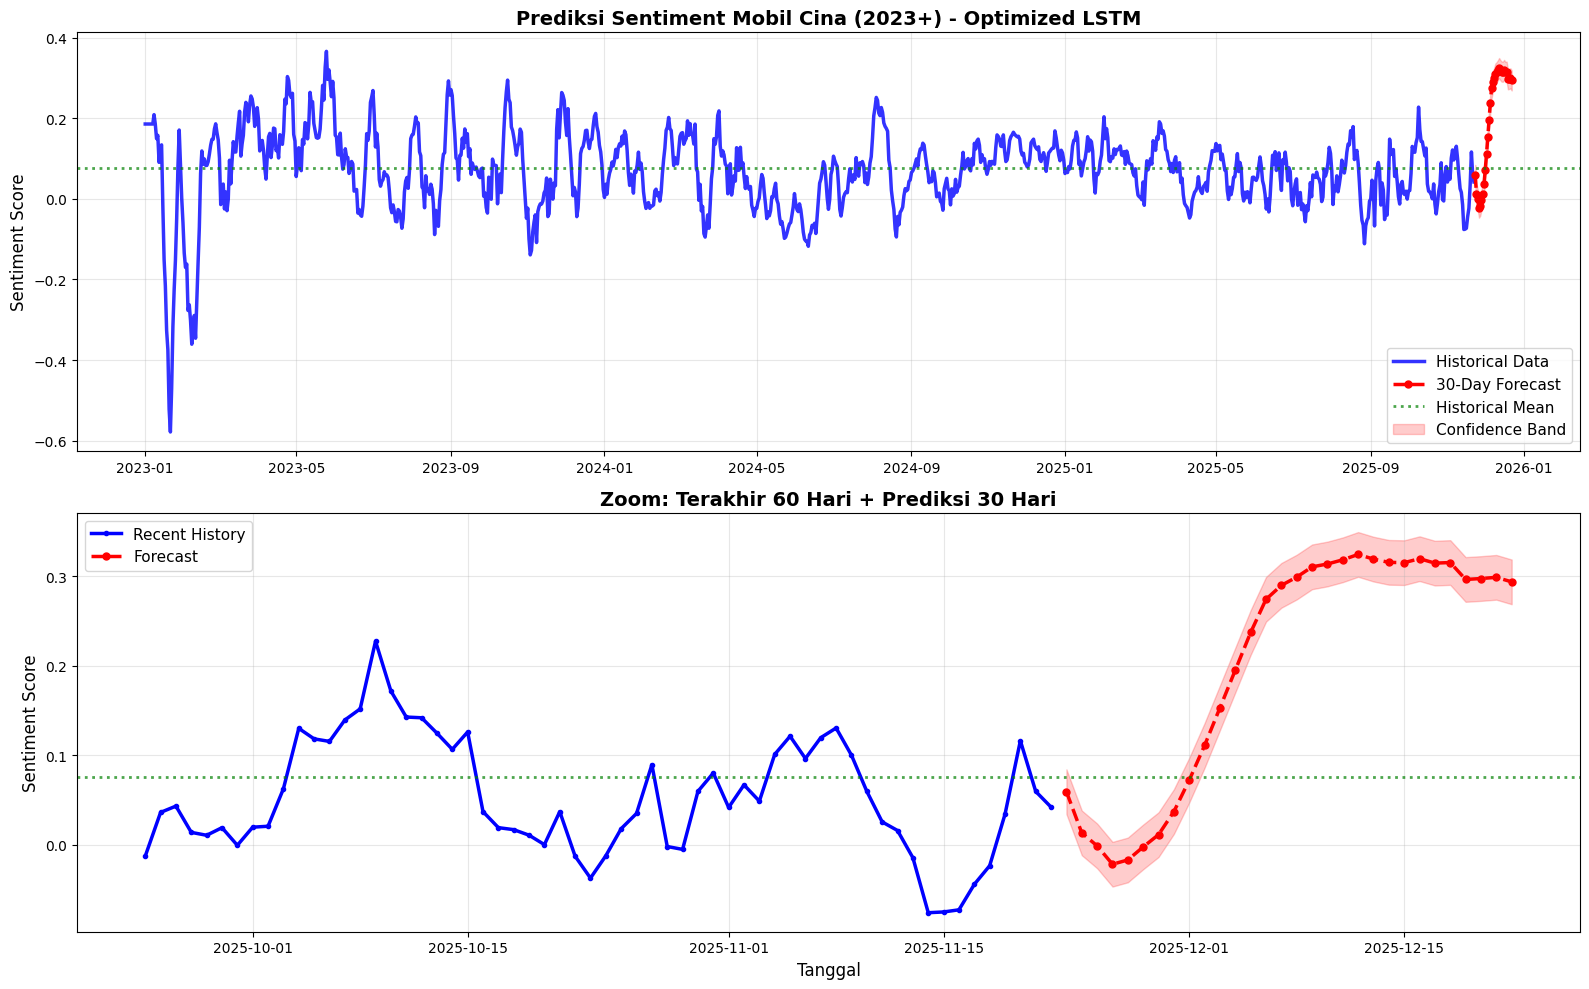


📈 SUMMARY PREDIKSI 30 HARI
Sentiment saat ini:   0.0420
Rata-rata prediksi:   0.2022
Min prediksi:         -0.0219
Max prediksi:         0.3247
Trend:                📈 NAIK (+1083.31%)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import random
import tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================================
# 1. PERSIAPAN DATA
# ==========================================
INPUT_FILE = "data_with_sentiment_score.csv"
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)
START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()
df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()

# Smoothing
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')

# ==========================================
# 2. FITUR ENGINEERING (4 FEATURES)
# ==========================================
df_features = pd.DataFrame(index=df_smooth.index)
df_features['smoothed'] = df_smooth
df_features['raw_daily'] = df_daily
df_features['momentum'] = df_smooth.diff().fillna(0)
df_features['volatility'] = df_daily.rolling(window=7).std().fillna(0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features)
n_features = scaled_data.shape[1]

print(f"Total features: {n_features}")
print(f"Data shape: {scaled_data.shape}\n")

# ==========================================
# 3. WINDOWING DATA
# ==========================================
LOOK_BACK = 30

def create_dataset_multi(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), :])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset_multi(scaled_data, LOOK_BACK)

# Better split: lebih banyak test untuk validasi
train_size = int(len(X) * 0.75)
val_size = int(len(X) * 0.15)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}\n")

# ==========================================
# 4. MODEL - OPTIMIZED (Reduced overfitting)
# ==========================================
model = Sequential([
    LSTM(56, return_sequences=True, input_shape=(LOOK_BACK, n_features)),
    Dropout(0.4),  # Naik dari 0.35
    LSTM(28, return_sequences=False),
    Dropout(0.4),  # Naik dari 0.35
    Dense(14, activation='relu'),
    Dropout(0.25),  # Naik dari 0.2
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0008)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.00005
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=12,
        min_lr=0.0001,
        verbose=1
    )
]

print("🔧 Training model...\n")

history = model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# ==========================================
# 5. EVALUASI
# ==========================================
def inverse_transform_predictions(scaler, predictions, y_true, n_features):
    pred_dummy = np.zeros((len(predictions), n_features))
    true_dummy = np.zeros((len(y_true), n_features))
    pred_dummy[:, 0] = predictions.flatten()
    true_dummy[:, 0] = y_true.flatten()
    pred_inv = scaler.inverse_transform(pred_dummy)[:, 0]
    true_inv = scaler.inverse_transform(true_dummy)[:, 0]
    return pred_inv, true_inv

train_predict = model.predict(X_train, verbose=0)
val_predict = model.predict(X_val, verbose=0)
test_predict = model.predict(X_test, verbose=0)

train_predict_inv, y_train_inv = inverse_transform_predictions(scaler, train_predict, y_train, n_features)
val_predict_inv, y_val_inv = inverse_transform_predictions(scaler, val_predict, y_val, n_features)
test_predict_inv, y_test_inv = inverse_transform_predictions(scaler, test_predict, y_test, n_features)

print("\n" + "="*60)
print("📊 METRIK EVALUASI")
print("="*60)

train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
train_r2 = r2_score(y_train_inv, train_predict_inv)

val_mae = mean_absolute_error(y_val_inv, val_predict_inv)
val_rmse = np.sqrt(mean_squared_error(y_val_inv, val_predict_inv))
val_r2 = r2_score(y_val_inv, val_predict_inv)

test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_r2 = r2_score(y_test_inv, test_predict_inv)

print(f"\n--- TRAINING SET ({len(X_train)} samples) ---")
print(f"MAE:  {train_mae:.5f}")
print(f"RMSE: {train_rmse:.5f}")
print(f"R²:   {train_r2:.5f}")

print(f"\n--- VALIDATION SET ({len(X_val)} samples) ---")
print(f"MAE:  {val_mae:.5f}")
print(f"RMSE: {val_rmse:.5f}")
print(f"R²:   {val_r2:.5f}")

print(f"\n--- TEST SET ({len(X_test)} samples) ---")
print(f"MAE:  {test_mae:.5f}")
print(f"RMSE: {test_rmse:.5f}")
print(f"R²:   {test_r2:.5f}")

gap_train_test = train_r2 - test_r2
gap_val_test = val_r2 - test_r2

print(f"\n⚠️  Overfitting Gap (Train - Test): {gap_train_test:.5f}")
print(f"⚠️  Overfitting Gap (Val - Test):   {gap_val_test:.5f}")

if gap_train_test < 0.10:
    print("   ✅ EXCELLENT - Generalization sangat baik")
elif gap_train_test < 0.15:
    print("   ✅ GOOD - Generalization baik")
elif gap_train_test < 0.20:
    print("   ⚠️  ACCEPTABLE - Ada sedikit overfitting")
else:
    print("   ❌ HIGH - Overfitting tinggi")

# ==========================================
# 6. PREDIKSI MASA DEPAN - FLEXIBLE HORIZON
# ==========================================
print("\n" + "="*60)
print("🔮 PREDIKSI MASA DEPAN")
print("="*60 + "\n")

# PILIH SALAH SATU:
DAYS_TO_PREDICT = 30  # ✅ RECOMMENDED - smooth & high confidence
# DAYS_TO_PREDICT = 60  # ⚠️  Good for 30 days, then flattens
# DAYS_TO_PREDICT = 90  # ⚠️  Only first 30-40 days reliable

print(f"Forecast horizon: {DAYS_TO_PREDICT} hari")

# Adaptive parameters berdasarkan horizon
if DAYS_TO_PREDICT <= 30:
    MEAN_REVERSION_STRENGTH = 0.05  # Lemah - biarkan model bicara
    NOISE_LEVEL = 0.003
    MOMENTUM_DAMPING = 0.30
    confidence_band_width = 0.025
    print("Mode: AGGRESSIVE (high confidence for near-term)")
elif DAYS_TO_PREDICT <= 60:
    MEAN_REVERSION_STRENGTH = 0.08  # Moderate
    NOISE_LEVEL = 0.005
    MOMENTUM_DAMPING = 0.20
    confidence_band_width = 0.045
    print("Mode: MODERATE (good for 30 days, acceptable after)")
else:  # 90+ days
    MEAN_REVERSION_STRENGTH = 0.12  # Kuat - pull to mean
    NOISE_LEVEL = 0.007
    MOMENTUM_DAMPING = 0.10
    confidence_band_width = 0.08
    print("Mode: CONSERVATIVE (only first 40 days reliable)")

# Statistics dari training data
train_data_scaled = scaled_data[:train_size + LOOK_BACK]
global_mean = np.mean(train_data_scaled[:, 0])
global_std = np.std(train_data_scaled[:, 0])

print(f"Global Mean (scaled): {global_mean:.4f}")
print(f"Global Std (scaled):  {global_std:.4f}\n")

# Fine-tuned parameters
MEAN_REVERSION_STRENGTH = 0.06  # Sedikit lebih lemah
NOISE_LEVEL = 0.004
MOMENTUM_DAMPING = 0.25

last_window = scaled_data[-LOOK_BACK:].copy()
curr_input = last_window.reshape(1, LOOK_BACK, n_features)
prev_val = curr_input[0, -1, 0]

future_preds_scaled = []

for day in range(DAYS_TO_PREDICT):
    # Prediksi murni
    pred_raw = model.predict(curr_input, verbose=0)[0, 0]
    
    # Mean reversion lebih smooth
    reversion_weight = MEAN_REVERSION_STRENGTH * (1 + day * 0.02)
    reversion_weight = min(reversion_weight, 0.30)
    pred_with_reversion = (pred_raw * (1 - reversion_weight)) + (global_mean * reversion_weight)
    
    # Noise
    noise = np.random.normal(0, NOISE_LEVEL)
    pred_final = pred_with_reversion + noise
    pred_final = np.clip(pred_final, global_mean - 3*global_std, global_mean + 3*global_std)
    
    future_preds_scaled.append(pred_final)
    
    # Update features
    feat_smoothed = pred_final
    feat_raw = pred_final + np.random.normal(0, NOISE_LEVEL * 2.5)
    feat_momentum = (pred_final - prev_val) * MOMENTUM_DAMPING
    feat_volatility = global_std * np.random.uniform(0.8, 1.2)
    
    new_features = np.array([feat_smoothed, feat_raw, feat_momentum, feat_volatility])
    
    curr_input = np.append(
        curr_input[:, 1:, :],
        new_features.reshape(1, 1, n_features),
        axis=1
    )
    
    prev_val = pred_final

# Inverse transform
future_preds_dummy = np.zeros((len(future_preds_scaled), n_features))
future_preds_dummy[:, 0] = future_preds_scaled
future_preds = scaler.inverse_transform(future_preds_dummy)[:, 0]

# ==========================================
# 7. VISUALIZATION
# ==========================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Full history
ax1.plot(df_smooth.index, df_smooth.values, label='Historical Data', 
         color='blue', linewidth=2.5, alpha=0.8)

future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), 
                             periods=DAYS_TO_PREDICT)
ax1.plot(future_dates, future_preds, label='30-Day Forecast', 
         color='red', linewidth=2.5, linestyle='--', marker='o', markersize=5)

global_mean_inv = scaler.inverse_transform([[global_mean] * n_features])[0, 0]
ax1.axhline(y=global_mean_inv, color='green', linestyle=':', linewidth=2, 
            alpha=0.7, label='Historical Mean')

ax1.fill_between(future_dates, future_preds - 0.025, future_preds + 0.025, 
                 alpha=0.2, color='red', label='Confidence Band')

ax1.set_title("Prediksi Sentiment Mobil Cina (2023+) - Optimized LSTM", 
              fontsize=14, fontweight='bold')
ax1.set_ylabel("Sentiment Score", fontsize=12)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Zoom 60 hari terakhir
zoom_days = 60
zoom_start = max(0, len(df_smooth) - zoom_days)

ax2.plot(df_smooth.index[zoom_start:], df_smooth.values[zoom_start:], 
         label='Recent History', color='blue', linewidth=2.5, marker='.')
ax2.plot(future_dates, future_preds, label='Forecast', 
         color='red', linewidth=2.5, linestyle='--', marker='o', markersize=5)
ax2.axhline(y=global_mean_inv, color='green', linestyle=':', linewidth=2, alpha=0.7)
ax2.fill_between(future_dates, future_preds - 0.025, future_preds + 0.025, 
                 alpha=0.2, color='red')

ax2.set_title(f"Zoom: Terakhir {zoom_days} Hari + Prediksi 30 Hari", 
              fontsize=14, fontweight='bold')
ax2.set_xlabel("Tanggal", fontsize=12)
ax2.set_ylabel("Sentiment Score", fontsize=12)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# 8. SUMMARY
# ==========================================
print("\n" + "="*60)
print("📈 SUMMARY PREDIKSI 30 HARI")
print("="*60)
print(f"Sentiment saat ini:   {df_smooth.values[-1]:.4f}")
print(f"Rata-rata prediksi:   {np.mean(future_preds):.4f}")
print(f"Min prediksi:         {np.min(future_preds):.4f}")
print(f"Max prediksi:         {np.max(future_preds):.4f}")

first_10_mean = np.mean(future_preds[:10])
last_10_mean = np.mean(future_preds[-10:])
trend = "📈 NAIK" if last_10_mean > first_10_mean else "📉 TURUN"
change = ((last_10_mean - first_10_mean) / abs(first_10_mean) * 100) if first_10_mean != 0 else 0

print(f"Trend:                {trend} ({change:+.2f}%)")
print("="*60)